In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import seaborn as sns
import cmocean
from panco2 import PressureProfileFitter
from utils import gNFW
import results
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.ndimage import gaussian_filter

# NIKA2-like

## Test 0

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, no transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test0/"

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=6.1
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)),
    np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30)),
    50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])
ppf.add_filtering(beam_fwhm=18.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=False)
results.set_plot_style("seaborn")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.5, imrange="sym")
fig, ax = plt.subplots()
ax.loglog(r_bins, P_bins, "o-")

### Fit

In [ ]:
path = "../tests/test0/"

ppf = PressureProfileFitter(
    f"{path}/map.fits", 1, 2,
    0.865, M_500=3.5e14, map_size=4.0,
)

r_bins = ppf.default_radial_binning(18.0 / 2)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.set_plot_style("seaborn")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

In [ ]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=5e2, max_delta_tau=0.01, min_autocorr_times=100, out_chains_file=f"{path}/raw_chains.npz")
results.plot_acf(ppf, max_delta_tau=0.01, min_autocorr_times=100)

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

## Test 1

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, no transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test1/"

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=4.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
gnfw_par = np.copy(ppf.cluster.A10_params)
gnfw_par[0] *= 3.2 / 8.4
gnfw_par[1] *= 1.0510 / 1.083
gnfw_par[2] = 1.40
gnfw_par[4] = 0.20
P_bins = gNFW(ppf.model.r_bins, *gnfw_par)
par_vec = np.append(P_bins, [-12.0, 0.0])
ppf.add_filtering(beam_fwhm=18.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

### Fit

In [ ]:
path = "../tests/test1/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
gnfw_par = np.copy(ppf.cluster.A10_params)
gnfw_par[0] *= 3.2 / 8.4
gnfw_par[1] *= 1.0510 / 1.083
gnfw_par[2] = 1.40
gnfw_par[4] = 0.20
P_bins = gNFW(ppf.model.r_bins, *gnfw_par)
par_vec = np.append(P_bins, [-12.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

## Test 2

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test2/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=5.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=False)
mapview.fitsview(f"{path}/map.fits", 1, smooth=1.0, imrange="sym")

### Fit

/Users/fkeruzore/.miniconda3/envs/panco2/lib/python3.10/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


(<Figure size 1000x500 with 4 Axes>,
 [<WCSAxesSubplot:xlabel='Right ascension (J2000)', ylabel='Declination (J200)'>,
  <WCSAxesSubplot:xlabel='Right ascension (J2000)', ylabel=' '>,
  <WCSAxesSubplot:xlabel='Right ascension (J2000)', ylabel=' '>])

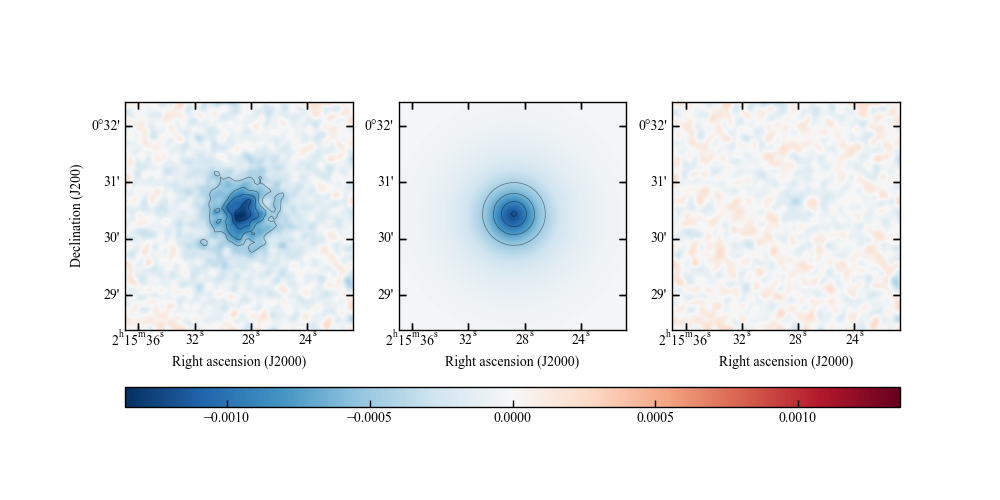

In [4]:
path = "../tests/test2/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
    map_size=4.0
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
plt.close("all")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

In [ ]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [5]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [6]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

AttributeError: module 'results' has no attribute 'plot_results'

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(ppf.autocorr[0], ppf.autocorr[1], "o-")
axs[1].semilogy(ppf.autocorr[0, 1:], np.ediff1d(ppf.autocorr[1]) / ppf.autocorr[1, :-1], "o-")

In [ ]:
np.roll(np.arange(5), 1)

## Test 3

- $M_{500} = 5.5 \times 10^{14} \, M_\odot$, $z= 0.565$
- A10 pressure profile
- 6 arcmin map, 18 arcsec FWHM beam, transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test3/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.565, M_500=5.5e14, map_size=6.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

### Fit

In [ ]:
path = "../tests/test3/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.565,
    M_500=5.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 8
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

# Non-NIKA2

## Test 4

- $M_{500} = 5 \times 10^{14} \, M_\odot$, $z = 0.1$
- A10 pressure profile
- 30 arcmin map, 1 arcmin FWHM beam, no transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test4/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/ACTlike.fits",
    1, 2, 0.1, M_500=5e14, map_size=61.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)), np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])

ppf.add_filtering(beam_fwhm=60.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=True)
results.set_plot_style("seaborn")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.0, imrange="sym")

### Fit

In [ ]:
path = "../tests/test4/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1, 2, 0.1, M_500=5e14, map_size=11.0
)

#r_bins = np.logspace(
#    np.log10(ppf.cluster.arcsec2kpc(30.0)), np.log10(ppf.cluster.arcsec2kpc(15.0 * 60)), 8
#)

r_bins = ppf.default_radial_binning(60.0)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=60.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(1.0, 0.1),
    zero=ss.norm(0.0, 1e-6)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=0)

In [ ]:
f = ppf.run_mcmc(30, 1e5, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
results.plot_acf(ppf, max_delta_tau=0.01, min_autocorr_times=100)

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 1000, 100)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
#results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, show_probs=False, filename=f"{path}/trace.png")
#fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
#fig.savefig(f"{path}/results.pdf")

# Point sources

In [ ]:
path = "../tests/test5/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=6.1
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)),
    np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30)),
    50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
ppf.add_filtering(beam_fwhm=18.0)
ppf.add_point_sources([SkyCoord("2h15m32.00s +00d29m30.00s"), SkyCoord("2h15m28.00s +00d31m00.00s")], 18.0)

par_vec = np.append(P_bins, [-12.0, 0.0, 1e-3, 2e-3])
ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=False)
results.set_plot_style("seaborn")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.75, imrange="sym")
fig, ax = plt.subplots()
ax.loglog(r_bins, P_bins, "o-")

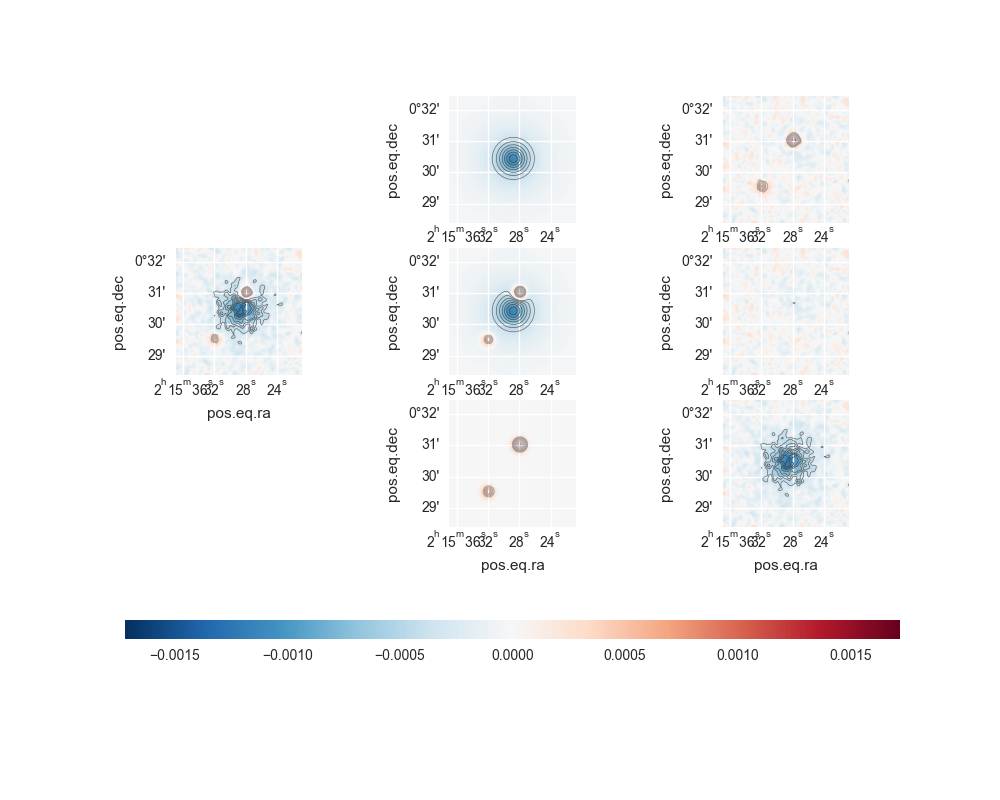

In [8]:
path = "../tests/test5/"

ppf = PressureProfileFitter(
    f"{path}/map.fits", 1, 2,
    0.865, M_500=3.5e14, map_size=4.0,
)

r_bins = ppf.default_radial_binning(18.0 / 2)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0, 1e-3, 2e-3])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.add_point_sources([SkyCoord("2h15m32.00s +00d29m30.00s"), SkyCoord("2h15m28.00s +00d31m00.00s")], 18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4),
    ps_fluxes=[ss.norm(1e-3, 5e-4), ss.norm(2e-3, 1e-2)],
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.set_plot_style("seaborn")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

In [ ]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=5e2, max_delta_tau=0.02, min_autocorr_times=50, out_chains_file=f"{path}/raw_chains.npz")
results.plot_acf(ppf, max_delta_tau=0.02, min_autocorr_times=50)

In [9]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 500, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")

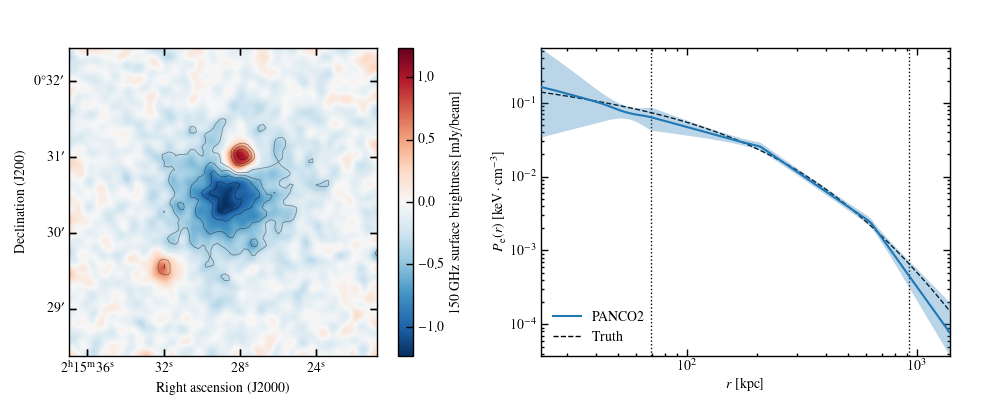

In [82]:
plt.close("all")
results.set_plot_style("paper")
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121, projection=ppf.wcs)
sz_map = 1e3 * gaussian_filter(ppf.sz_map, 1.0)
sz_rms = 1e3 * gaussian_filter(ppf.sz_rms, 1.0) / np.sqrt(2 * np.pi)
vmin, vmax = np.min(sz_map), np.max(sz_map)
vmax = np.max(np.abs([vmin, vmax]))
vmin = -vmax
im = ax.imshow(
    sz_map,
    origin="lower",
    vmin=vmin,
    vmax=vmax,
    interpolation="gaussian",
    cmap="RdBu_r",
)
ct = ax.contour(
    sz_map / sz_rms,
    origin="lower",
    linestyles="-",
    colors="#00000077",
    linewidths=0.5,
    levels=np.concatenate((np.arange(-50, -2, 2), np.arange(3, 50, 2))),
)
ax.set_xlabel("Right ascension (J2000)")
ax.set_ylabel("Declination (J200)")
cb = fig.colorbar(im, ax=ax)
cb.set_label("150 GHz surface brightness [mJy/beam]")

ax = fig.add_subplot(122)
r_range = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)),
    np.log10(ppf.cluster.arcsec2kpc(1.5 * ppf.map_size * 30)),
    100
)
results.plot_profile(chains_clean, ppf, r_range, label="PANCO2", ax=ax, lw=1.5)
ax.plot(r_range, gNFW(r_range, *ppf.cluster.A10_params), "k--", label="Truth")
ax.legend(frameon=False)
results.ax_bothticks(ax)

fig.subplots_adjust(left=0.05, right=0.95)
fig.savefig(f"{path}/prof.png", dpi=200)

In [71]:
ppf.cluster.arcsec2kpc(ppf.map_size * 60.0 / 2.0)

924.0244399900581